In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm
import pandas as pd
import os

weights = ResNet50_Weights.DEFAULT

# dataset from https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset
dataset = ImageFolder('dataset', transform = weights.transforms()) # Transfrom the images for ResNet

Label 0


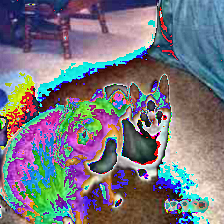

In [2]:
# Sample Image
sample = dataset[1]

print("Label", sample[1]) # {Cat = 0, Dog = 1}
transforms.ToPILImage()(sample[0]) # Image after transforms

In [3]:
total_samples = len(dataset)
batch_size = 128
num_batches = (total_samples + batch_size - 1) // batch_size 

# Load dataset into DataLoader (batch_size based on PC specs)
loader = DataLoader(dataset, batch_size = batch_size, shuffle = False)

# Initialize the model for embedding
resnet = resnet50(weights = weights)
resnet.eval() # No need to train, set eval
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1]) # Remove end classification layer

embeddings = []
labels = []
filenames = []

with torch.no_grad():
    for imgs, lbls in tqdm(loader, total=num_batches, desc="Extracting embeddings"):
        features = feature_extractor(imgs)  # [B, 2048, 1, 1]
        features = features.view(features.size(0), -1)  # Flatten to [B, 2048]
        embeddings.extend(features.numpy())
        labels.extend(lbls.numpy())

filenames = [os.path.basename(path[0]) for path in dataset.samples]

# Save to CSV
df = pd.DataFrame(embeddings)
df['label'] = labels
df['filename'] = filenames
df.to_csv("embeddings.csv", index=False)

Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 16/16 [06:46<00:00, 25.43s/it]
